In [1]:
import os
os.environ["WEBBPSF_PATH"] = 'webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = 'webbpsf-data'
os.environ["PYSYN_CDBS"] = "cdbs"

from astropy.io import fits

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.3'

jax.config.update("jax_enable_x64", True)

#### Loading Files

In [2]:
import pandas as pd

#image_data = pd.read_csv('statistical_analysis/image_info_filt.csv')
#image_data.set_index("Name", inplace=True)
#image_data.columns = ["Radius", "Inclination", "Position Angle", "Distance", "Knots"]
#print(image_data)

row = {'Name': 'hd111161_H_pol', 'Radius': 72.4, 'Inclination': 62.1, "Position Angle": 263.2, "Distance": 109.43, "Knots": 7,}

### Processing Fits File

/home/mihirkondapalli/anaconda3/envs/jwst_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.
Could not import CuPy. Setting: use_gpu=False (i.e., using CPU operations).
Filename: test_images/hd111161_H_pol.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     686   ()      
  1  SCI           1 ImageHDU       140   (281, 281, 4)   float32   
  2  DQ            3 ImageHDU        64   (281, 281, 2)   uint8   


Text(0.5, 1.0, 'Image from Fits File')

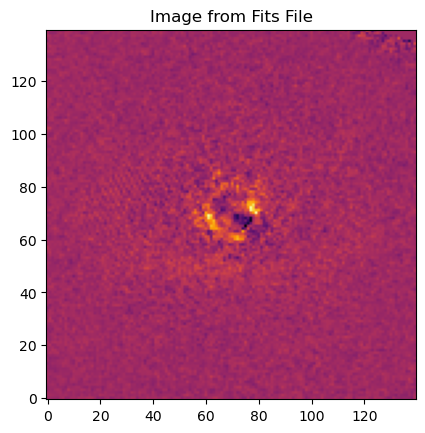

In [3]:
from statistical_analysis.optimize_framework import OptimizeUtils

fits_image_filepath = "test_images/" + row['Name'] + ".fits"
hdul = fits.open(fits_image_filepath)

#Displays File Info
hdul.info()

# Gets Image
target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:])

# Displays Image
plt.imshow(target_image, origin='lower', cmap='inferno')
plt.title("Image from Fits File")

## Getting Optimal Disk Fit

In [4]:
from statistical_analysis.optimize_framework import Optimizer, OptimizeUtils
from utils.objective_functions import objective_model, objective_ll, objective_fit, Parameter_Index
from utils.SLD_ojax import ScatteredLightDisk
from utils.SLD_utils import *

### Getting Optimal Fit

In [5]:

target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:])
err_map = OptimizeUtils.process_image(OptimizeUtils.create_empirical_err_map(hdul['SCI'].data[2,:,:])) #, outlier_pixels=[(57, 68)]))

In [6]:
start_disk_params = Parameter_Index.disk_params.copy()
start_spf_params = InterpolatedUnivariateSpline_SPF.params.copy()
start_psf_params = EMP_PSF.params.copy()
start_misc_params = Parameter_Index.misc_params.copy()

start_disk_params = Parameter_Index.disk_params.copy()
start_disk_params['sma'] = row["Radius"]
start_disk_params['inclination'] = row["Inclination"]
start_disk_params['position_angle'] = row["Position Angle"]

start_spf_params['num_knots'] = 7 # int(row["Knots"])

start_misc_params['distance'] = row["Distance"]

opt = Optimizer(start_disk_params, start_spf_params, start_psf_params, start_misc_params, 
                ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF)

opt.inc_bound_knots() # call this method only if you have a good predifined inclination, otherwise don't use it
opt.scale_initial_knots(target_image)

print(opt.log_likelihood(target_image, err_map))

-36244.04209456009


Text(0.5, 1.0, 'Initial Guess, Log-Likel+1e-14+ dsfdihood: -36244.04209456009')

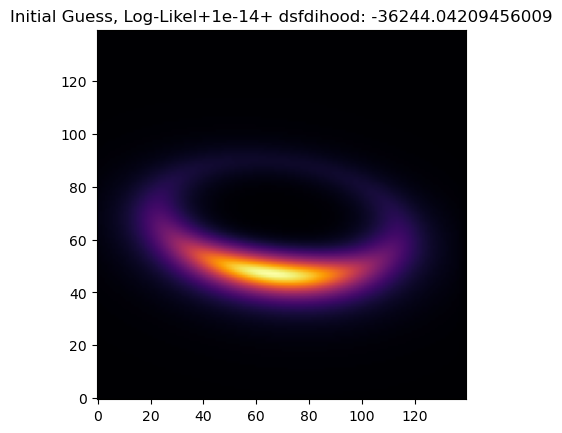

In [7]:
plt.imshow(opt.model(), origin='lower', cmap='inferno')
plt.title("Initial Guess, Log-Likel+1e-14+ dsfdihood: " + str(opt.log_likelihood(target_image, err_map)))

In [8]:
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': 5, 'alpha_out': -5, 'sma': 72.4, 'e': 0.0, 'ksi0': 3.0, 'gamma': 2.0, 'beta': 1.0, 'rmin': 0.0, 'dens_at_r0': 1.0, 'inclination': 62.1, 'position_angle': 263.2, 'x_center': 70.0, 'y_center': 70.0, 'halfNbSlices': 25, 'omega': 0.0}
SPF Params: {'low_bound': Array(-0.88376563, dtype=float64, weak_type=True), 'up_bound': Array(0.88376563, dtype=float64, weak_type=True), 'num_knots': 7, 'knot_values': Array([6.30559932, 2.60158116, 1.49650907, 1.        , 0.72802418,
       0.56031171, 0.44837867], dtype=float64)}
PSF Params: {'scale_factor': 1, 'offset': 1}
Misc Params: {'distance': 109.43, 'pxInArcsec': 0.01414, 'nx': 140, 'ny': 140, 'halfNbSlices': 25, 'flux_scaling': Array(82.1868579, dtype=float64)}


In [9]:
# Running optimization method
fit_keys = ['alpha_in', 'alpha_out', 'sma', 'inclination', 'position_angle', 'x_center', 'y_center', 'knot_values', 'flux_scaling']
bounds = ([0.1, -15, 0, 0, 0, 65, 65, np.zeros(7), 0],
          [15, -0.1, 150, 180, 400, 75, 75, 1e4*np.ones(7), 5e3])

opt.scipy_optimize(fit_keys, target_image, err_map, fit_bounds=bounds, disp_soln=True, iters = 1000)
optimal_image = opt.model()

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 35688.81692256073
        x: [ 4.107e+00 -4.000e+00 ...  4.762e-01  8.219e+01]
      nit: 24
      jac: [-1.633e+00  2.611e+00 ... -7.503e+00  0.000e+00]
     nfev: 1552
     njev: 97
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>


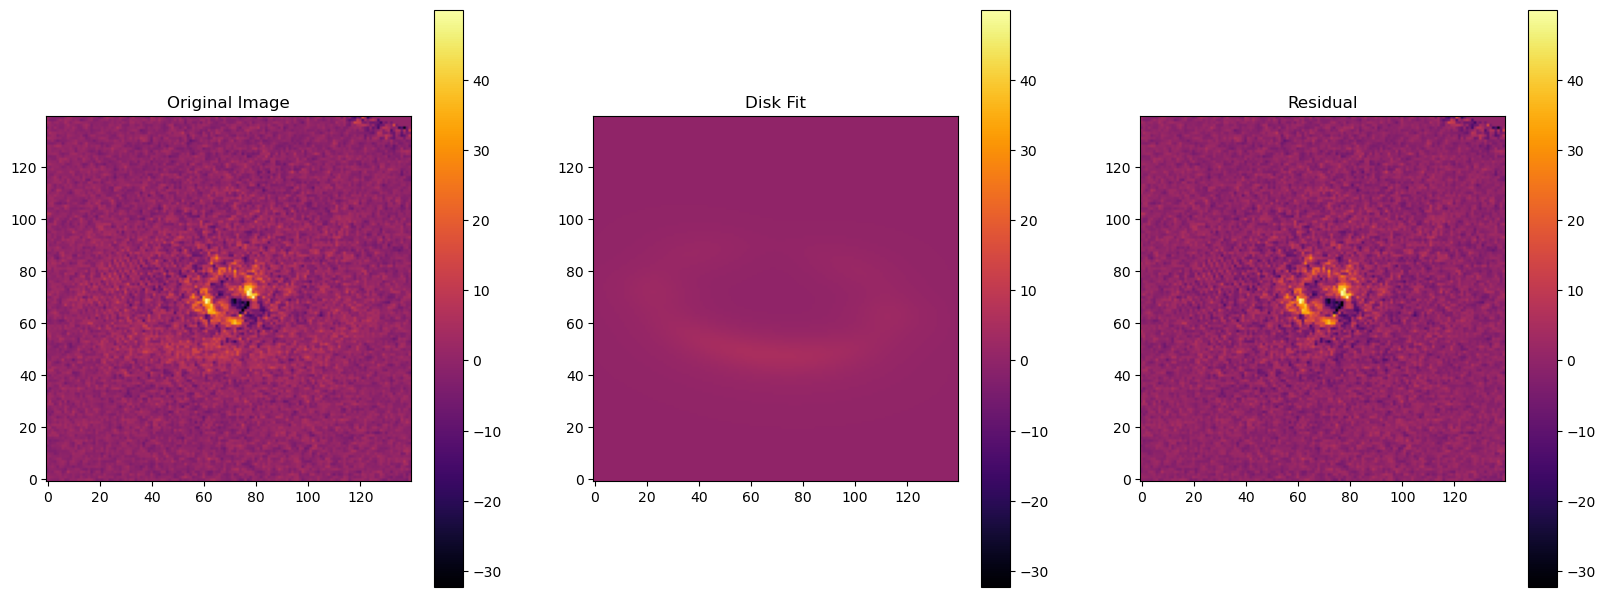

In [10]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[1].imshow(optimal_image, origin='lower', cmap='inferno')
axes[1].set_title("Disk Fit")
plt.colorbar(im, ax=axes[1], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[2].imshow(target_image-optimal_image, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)
im.set_clim(vmin, vmax)

In [11]:
opt.scale_spline_to_fixed_point(0, 1)
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': np.float64(4.107427500270645), 'alpha_out': np.float64(-3.9999466499544414), 'sma': np.float64(72.47679936431011), 'e': 0.0, 'ksi0': 3.0, 'gamma': 2.0, 'beta': 1.0, 'rmin': 0.0, 'dens_at_r0': 1.0, 'inclination': np.float64(62.27671673779979), 'position_angle': np.float64(264.07859034624295), 'x_center': np.float64(69.93440982293964), 'y_center': np.float64(70.73595386988059), 'halfNbSlices': 25, 'omega': 0.0}
SPF Params: {'low_bound': Array(-0.88376563, dtype=float64, weak_type=True), 'up_bound': Array(0.88376563, dtype=float64, weak_type=True), 'num_knots': 7, 'knot_values': Array([2.01324821, 1.13099964, 0.81802741, 1.        , 0.57292221,
       0.66922035, 0.2078859 ], dtype=float64)}
PSF Params: {'scale_factor': 1, 'offset': 1}
Misc Params: {'distance': 109.43, 'pxInArcsec': 0.01414, 'nx': 140, 'ny': 140, 'halfNbSlices': 25, 'flux_scaling': Array(636.51010571, dtype=float64)}


## Running MCMC

In [12]:
# For MCMC, spline values are log scaled, the optimizer class passes them in as log(spf_params) and they are exponated in the lambda expression, this evens out the markov chains
# helping MCMC work better

fit_keys = ['alpha_in', 'alpha_out', 'sma', 'inclination', 'position_angle', 'x_center', 'y_center', 'knot_values', 'flux_scaling']
bounds = ([0.1, -15, 0, 0, 0, 65, 65, np.zeros(7), 0],
          [15, -0.1, 150, 180, 400, 75, 75, 1e4*np.ones(7), 5e3])

mc_model = opt.mcmc(fit_keys, target_image, err_map, bounds, nwalkers=100, niter=100, burns=20)

Running burn-in...


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Running production...


100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


In [13]:
mc_soln = np.median(mc_model.sampler.flatchain, axis=0)
img = opt.model()

Text(0.5, 1.0, 'Post MCMC')

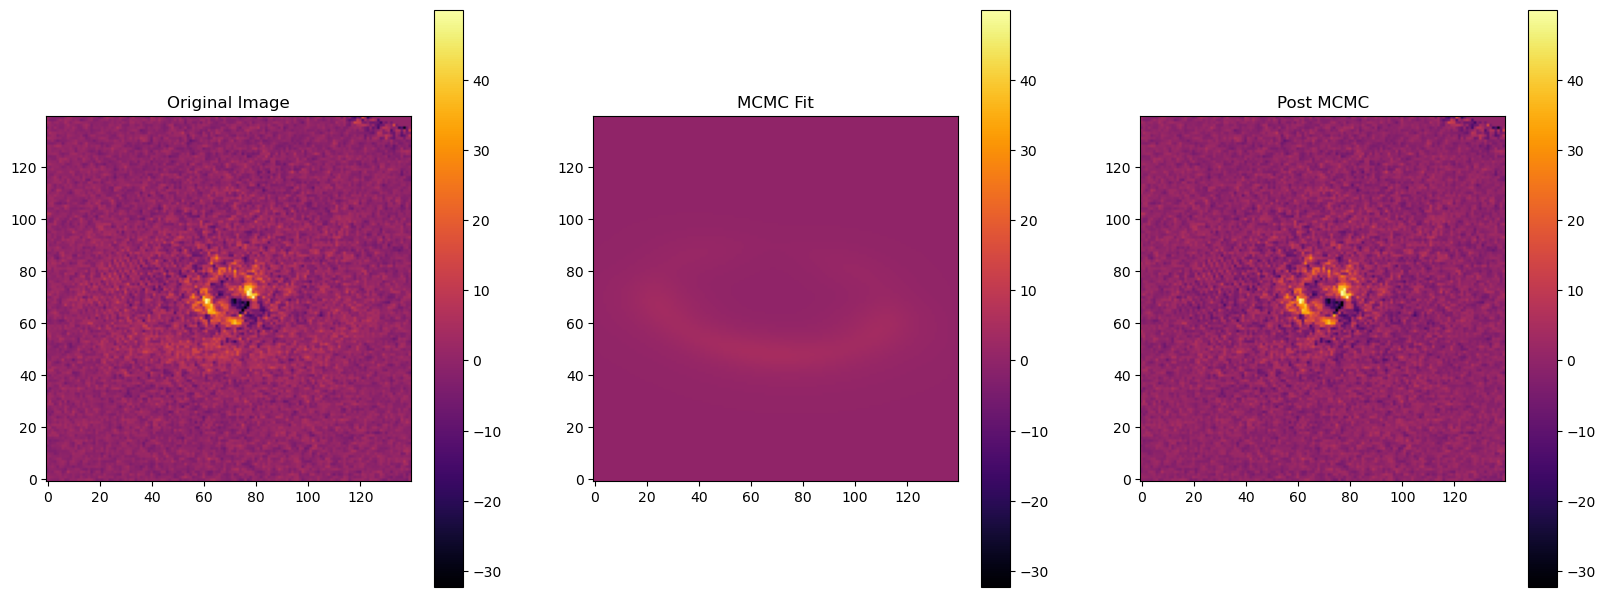

In [14]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[1].imshow(img, origin='lower', cmap='inferno')
axes[1].set_title("MCMC Fit")
plt.colorbar(im, ax=axes[1], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[2].imshow(target_image-img, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)
im.set_clim(vmin, vmax)
plt.title("Post MCMC")

### Plotting MCMC Results

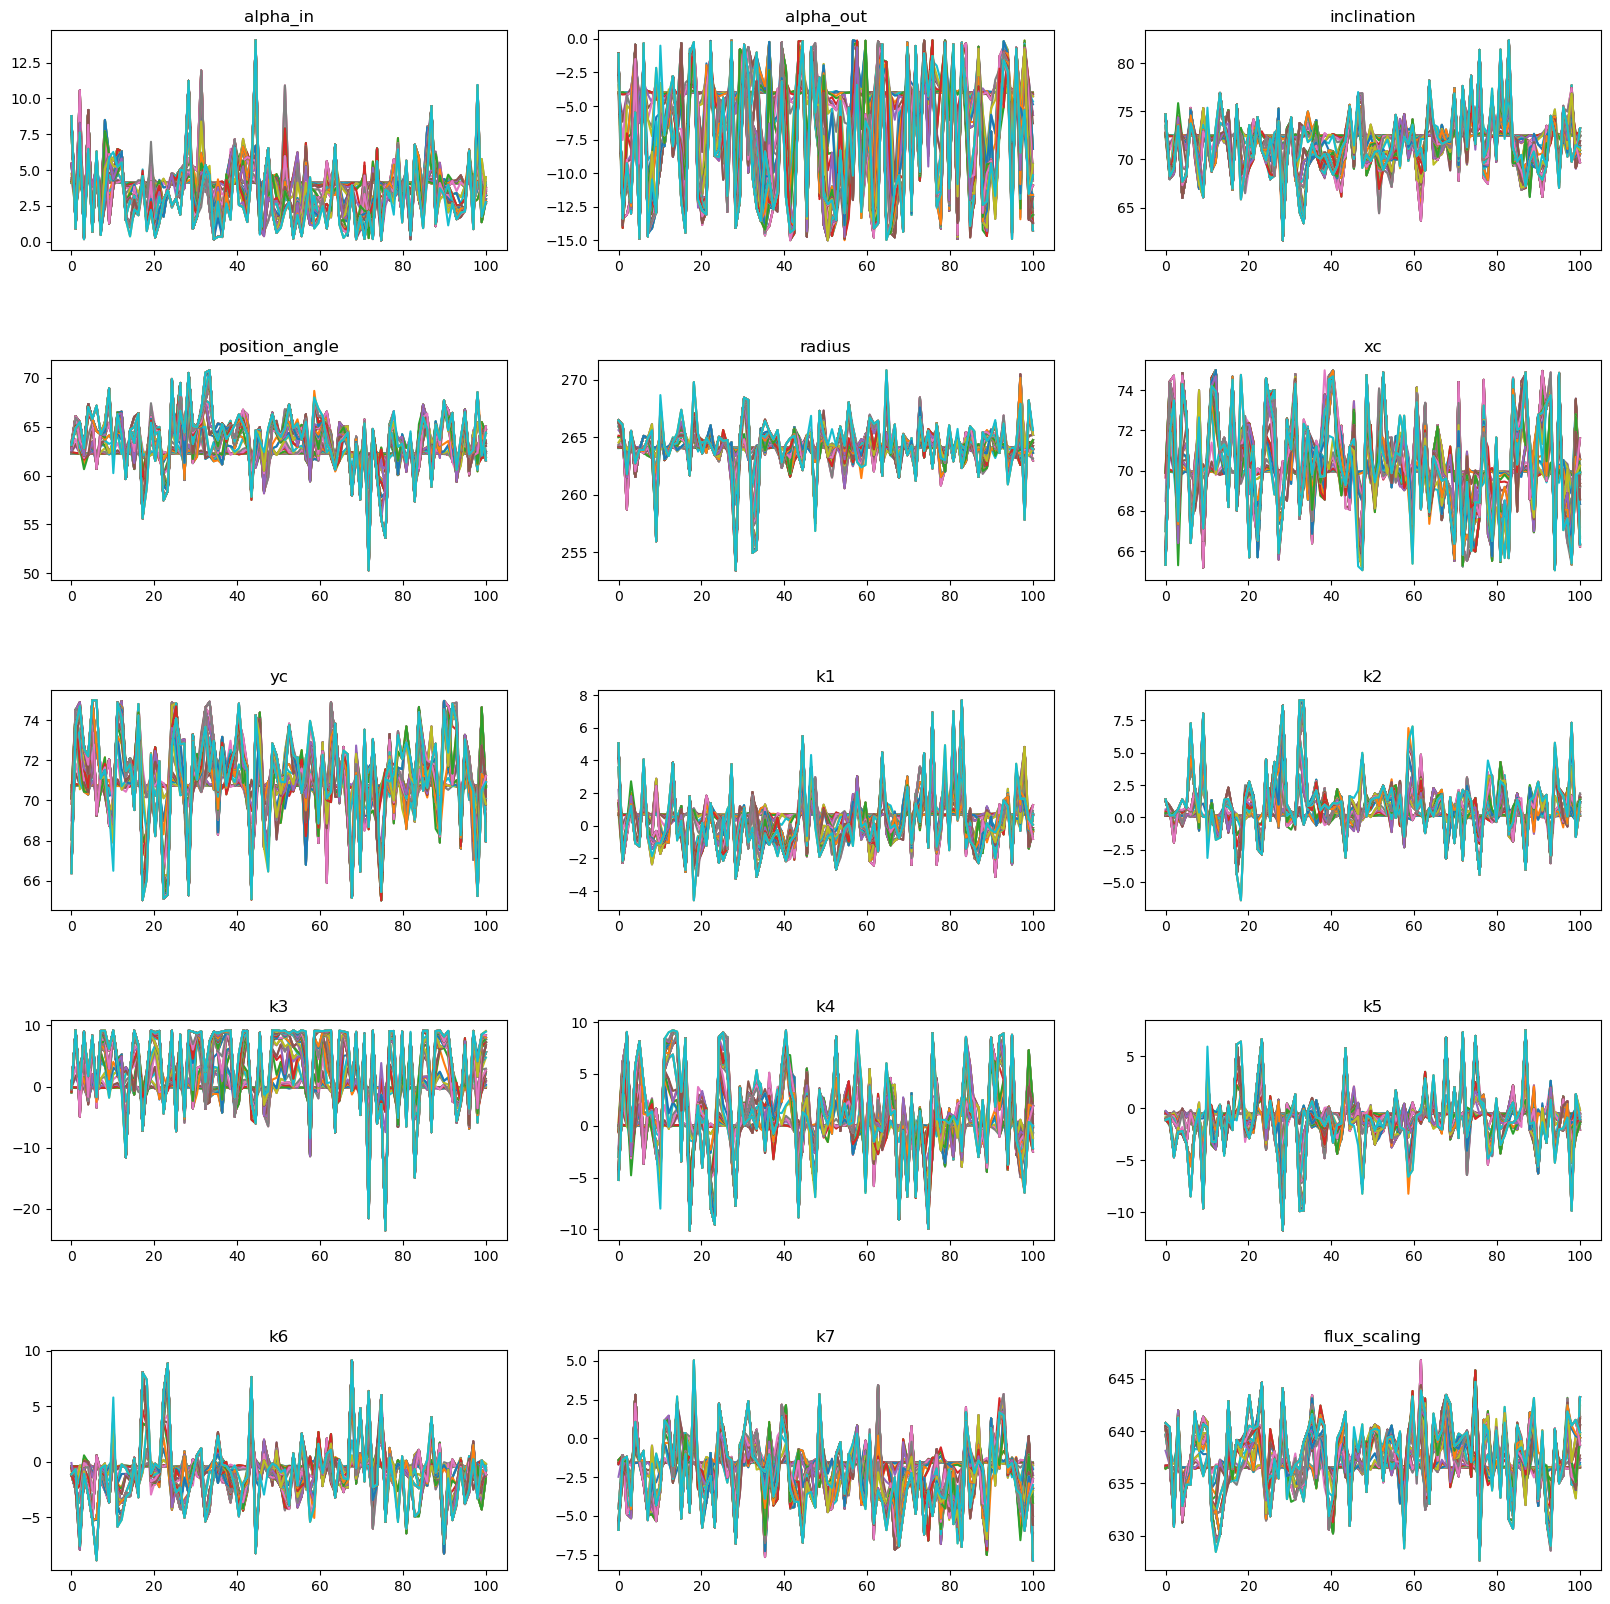

In [15]:
labels = ['alpha_in', 'alpha_out', 'inclination', 'position_angle', 'radius', 'xc', 'yc']
for i in range(0, opt.spf_params['num_knots']):
    labels.append('k'+str(i+1))
labels.append('flux_scaling')
mc_model.plot_chains(labels)

[      root:WARNING] Too few points to create valid contours


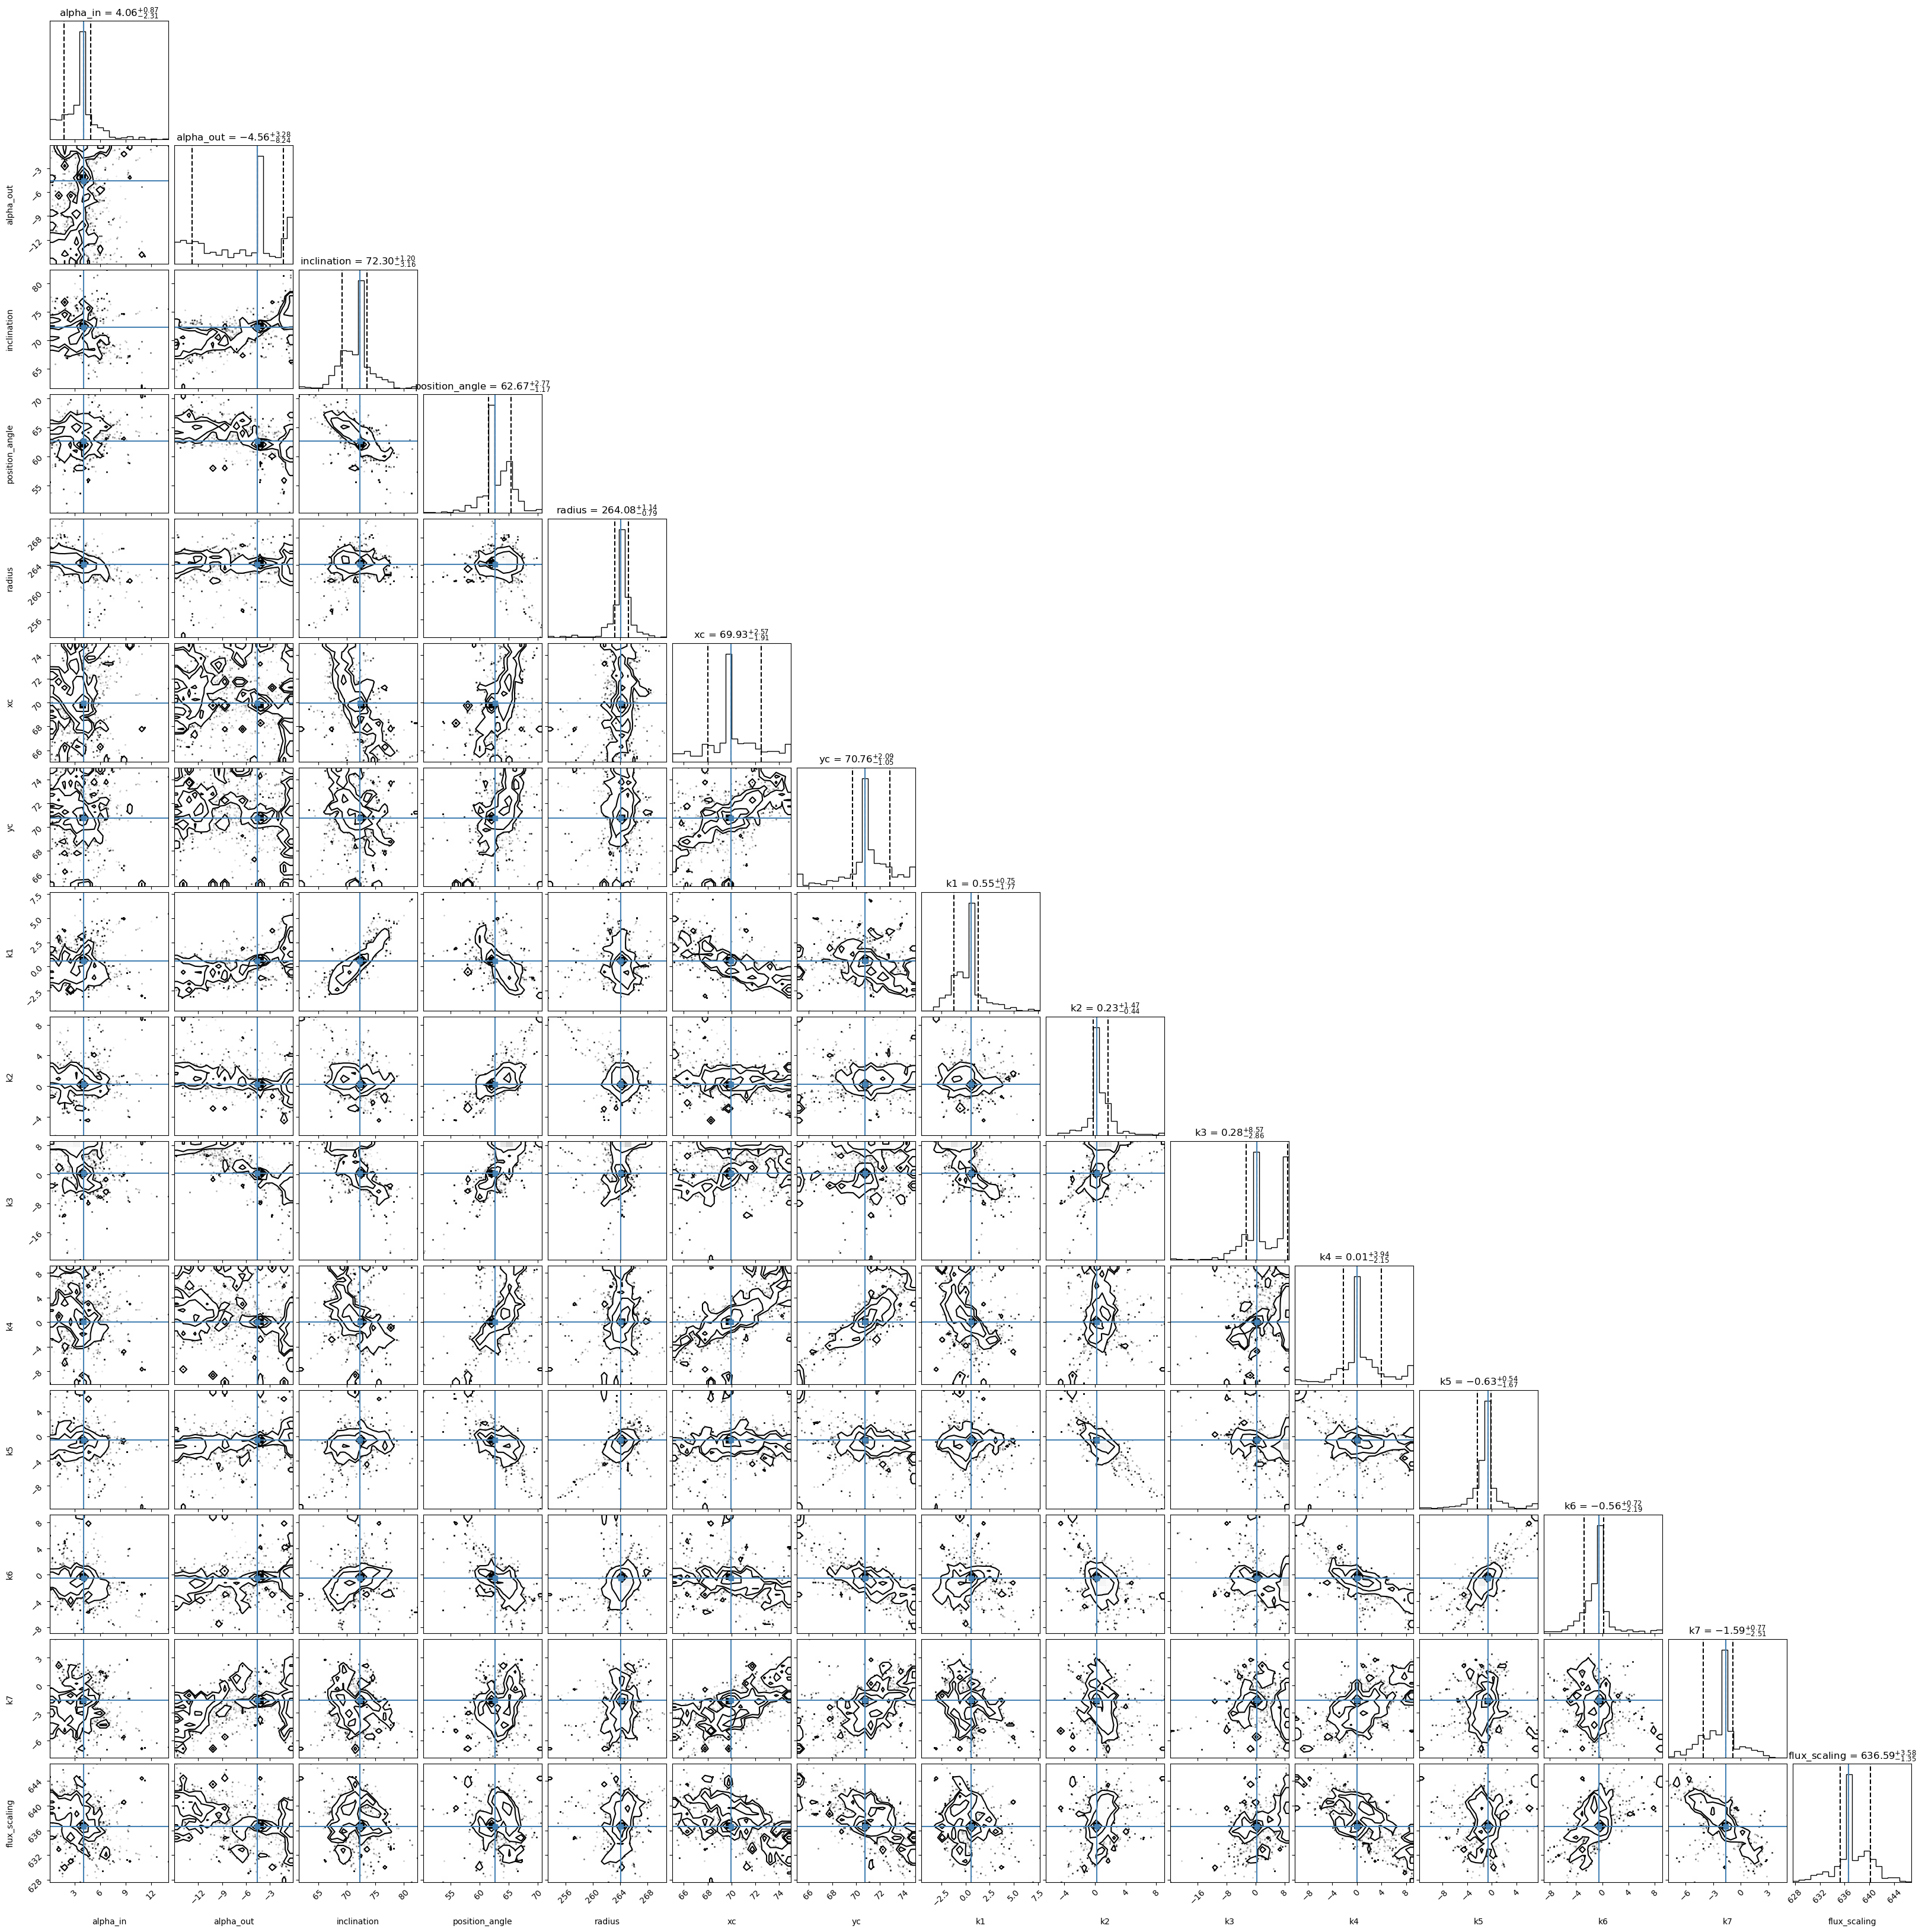

In [16]:
mc_model.show_corner_plot(labels, truths=mc_soln)